### Subreddits
https://www.reddit.com/r/snowboarding/

https://www.reddit.com/r/skiing/

#### api links
api.pushshift.io/reddit/search/?subreddit=snowboarding

http://api.pushshift.io/reddit/comment/search/?subreddit=skiing

https://github.com/pushshift/api

parameters: https://pushshift.io/api-parameters/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Thanks to Hov, he inspired me to create a separate notebook that contained
# my functions so I could import them instead of having them take up so much 
# space
from functions import cvec_df,ski_and_sb_stopword_list,model_confusion_matrix

In [2]:
np.random.seed(42)

## Import Comments

In [3]:
# import data
sb_v_ski = pd.read_csv('./data/all_comment_data_5000.csv',index_col = 0)
sb = pd.read_csv('./data/sb_comment_data_5000.csv',index_col = 0)
ski = pd.read_csv('./data/ski_comment_data_5000.csv',index_col = 0)

In [4]:
pd.set_option('display.max_columns',100)

## Stop Word Lists

In [5]:
# instantiate stopword list
stop_words_list = ski_and_sb_stopword_list()

## Count Vectorizing

In [6]:
# CountVectorize all comments
comment_df = cvec_df(sb_v_ski,'stemmed comments',stop_words_list)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'heli', 'jumping', 'nordic', 'speed'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


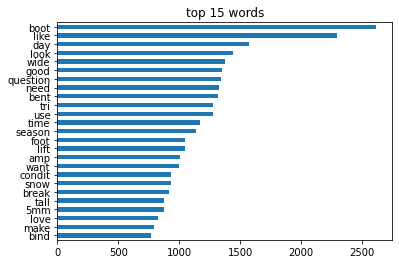

In [7]:
# analyze top 15 words
comment_df.sum().sort_values(ascending = False).head(25).plot(kind = 'barh', title = 'top 15 words')

plt.gca().invert_yaxis();

### Ski Count Vectorizer

In [8]:
# CountVectorize skiing comments
ski_comment_df = cvec_df(ski,'stemmed comments',stop_words_list)

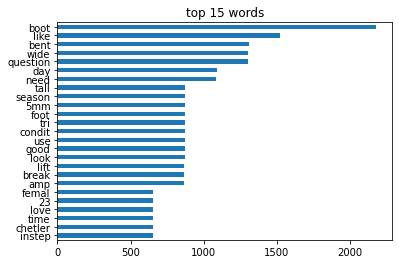

In [9]:
# analyze top 15 words from skiing comments
ski_comment_df.sum().sort_values(ascending = False).head(25).plot(kind = 'barh', title = 'top 15 words')

plt.gca().invert_yaxis();

### Snowboarding Count Vectorizer

In [10]:
# CountVectorize snowboarding comments
sb_comment_df = cvec_df(sb,'stemmed comments',stop_words_list)

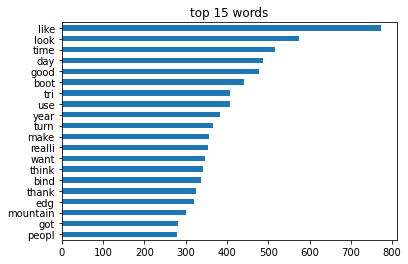

In [11]:
# analyze top 15 words from snowboarding comments
sb_comment_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', title = 'top 15 words')

plt.gca().invert_yaxis();

## Model Set Up

Due to Gridsearch automatically train test splitting data by using cross validation, there is no need so train test split the X and y variables.

Additionally, baseline accuracy is 50% since the classes are perfectly balanced.

In [12]:
# set feature (X) and target (y) variables
X = sb_v_ski['stemmed comments']

y = sb_v_ski['ski or sb']

## Naive Bayes
### Count Vectorizer

In [13]:
# set up Pipeline
nb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('nb', MultinomialNB())
])

In [14]:
# set parameters
nb_pipe_params = {
    'cvec__max_features': [5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,1),(1,2),(2,2),(3,3),(1,3)],
    'nb__alpha': [0,1]
}

In [15]:
# set up GridSearch
nb_cvec = GridSearchCV(
    estimator = nb_pipe,
    param_grid = nb_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [16]:
# fit GridSearch
nb_cvec.fit(X,y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   18.8s finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'heli', 'jumping', 'nordic', 'speed'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [17]:
# look at best parameters
nb_cvec.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 5000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'nb__alpha': 0}

In [18]:
# look at best scores
nb_cvec.best_score_

0.8798

In [19]:
# Thanks to Hov I was able to learn about .cv_results_ (I was running a ton
# of different gridsearches prior to that)
# turn results into a dataframe
nb_cvec_results = pd.DataFrame(nb_cvec.cv_results_)

In [20]:
# look at GridSearch results
nb_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_nb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.307077,0.003985,0.068395,0.001442,0.95,5000,0.01,"(1, 1)",0,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8180,0.8180,0.8120,0.8005,0.8085,0.8114,0.006553,6
1,0.301422,0.022857,0.066840,0.001802,0.95,5000,0.01,"(1, 1)",1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8180,0.8185,0.8125,0.8015,0.8080,0.8117,0.006392,5
2,0.551212,0.014902,0.141026,0.008841,0.95,5000,0.01,"(1, 2)",0,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8675,0.8840,0.8770,0.8700,0.8735,0.8744,0.005774,3
3,0.589362,0.013171,0.128447,0.010192,0.95,5000,0.01,"(1, 2)",1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8695,0.8845,0.8770,0.8705,0.8745,0.8752,0.005381,2
4,0.459593,0.021140,0.092098,0.009875,0.95,5000,0.01,"(2, 2)",0,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.5285,0.5285,0.5270,0.5280,0.5260,0.5276,0.000970,25
5,0.468900,0.021071,0.105948,0.009320,0.95,5000,0.01,"(2, 2)",1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.5305,0.5075,0.5065,0.5080,0.5040,0.5113,0.009698,26
6,0.493565,0.003817,0.108097,0.005208,0.95,5000,0.01,"(3, 3)",0,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.5000,0.5005,0.5015,0.5000,0.5000,0.5004,0.000583,27
7,0.482573,0.020390,0.097400,0.012041,0.95,5000,0.01,"(3, 3)",1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.4785,0.4785,0.4580,0.5000,0.4785,0.4787,0.013284,32
8,0.969080,0.012726,0.180169,0.008136,0.95,5000,0.01,"(1, 3)",0,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8755,0.8875,0.8855,0.8740,0.8765,0.8798,0.005564,1
9,0.972201,0.035028,0.210792,0.037426,0.95,5000,0.01,"(1, 3)",1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8545,0.8675,0.8640,0.8545,0.8555,0.8592,0.005474,4


In [21]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
nb_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.8798
0.025    0.6353
0.030    0.6364
0.050    0.5763
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [22]:
# set up Pipeline
nb2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('nb', MultinomialNB())
])

In [23]:
# set parameters
nb2_pipe_params = {
    'tvec__max_features': [5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,1),(1,2),(2,2),(3,3),(1,3)],
    'nb__alpha': [0,1]
}

In [24]:
# set up GridSearch
nb_tvec = GridSearchCV(
    estimator = nb2_pipe,
    param_grid = nb2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [25]:
# fit GridSearch
nb_tvec.fit(X,y)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   17.4s finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'heli', 'jumping', 'nordic', 'speed'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [26]:
# look at best parameters
nb_tvec.best_params_

{'nb__alpha': 1,
 'tvec__max_df': 0.95,
 'tvec__max_features': 5000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 3)}

In [27]:
# look at best scores
nb_tvec.best_score_

0.9207000000000001

In [28]:
# turn results into a dataframe
nb_tvec_results = pd.DataFrame(nb_tvec.cv_results_)

In [29]:
# look at GridSearch results
nb_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__alpha,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.272153,0.012146,0.071128,0.003855,0,0.95,5000,0.01,"(1, 1)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.8830,0.9055,0.8955,0.8875,0.8855,0.8914,0.008200,6
1,0.614784,0.016897,0.130053,0.004882,0,0.95,5000,0.01,"(1, 2)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.9075,0.9255,0.9180,0.9120,0.9080,0.9142,0.006787,4
2,0.465411,0.005699,0.102268,0.006318,0,0.95,5000,0.01,"(2, 2)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.5275,0.5280,0.5270,0.5270,0.5255,0.5270,0.000837,25
3,0.464020,0.008700,0.100156,0.005743,0,0.95,5000,0.01,"(3, 3)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.5000,0.5005,0.5015,0.5000,0.5000,0.5004,0.000583,26
4,0.923023,0.015250,0.182032,0.006477,0,0.95,5000,0.01,"(1, 3)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.9125,0.9305,0.9240,0.9155,0.9130,0.9191,0.007038,2
5,0.304433,0.010450,0.070703,0.005138,0,0.95,5000,0.025,"(1, 1)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.7975,0.7995,0.7910,0.8015,0.7835,0.7946,0.006576,8
6,0.619951,0.009591,0.128229,0.003573,0,0.95,5000,0.025,"(1, 2)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.7965,0.8005,0.7905,0.8010,0.7840,0.7945,0.006458,11
7,0.484396,0.011987,0.099706,0.007658,0,0.95,5000,0.025,"(2, 2)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.4905,0.4925,0.4930,0.4895,0.4900,0.4911,0.001393,29
8,0.473789,0.009866,0.000000,0.000000,0,0.95,5000,0.025,"(3, 3)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
9,0.901172,0.023977,0.194100,0.015824,0,0.95,5000,0.025,"(1, 3)","{'nb__alpha': 0, 'tvec__max_df': 0.95, 'tvec__...",0.7965,0.8005,0.7905,0.8010,0.7840,0.7945,0.006458,11


In [30]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
nb_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.9207
0.025    0.7949
0.030    0.7584
0.050    0.6297
Name: mean_test_score, dtype: float64

## Random Forest
### Count Vectorizer

In [31]:
# set up Pipeline
rf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('rf', RandomForestClassifier())
])

In [32]:
# set parameters
rf_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'rf__n_estimators': [1,10,100,150],
    'rf__max_depth': [2,3],
    'rf__min_samples_split' : [5,10],
    'rf__min_samples_leaf' : [2,3],
}

In [33]:
# set up GridSearch
rf_cvec = GridSearchCV(
    estimator = rf_pipe,
    param_grid = rf_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [34]:
# fit GridSearch
rf_cvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   18.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   58.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 11.0min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 14.7min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 17.5min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 20.6min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 24.0min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 27.5mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [35]:
# look at best parameters
rf_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'rf__max_depth': 3,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 10}

In [36]:
# look at best scores
rf_cvec.best_score_

0.7975

In [37]:
# turn results into a dataframe
rf_cvec_results = pd.DataFrame(rf_cvec.cv_results_)

In [38]:
# look at GridSearch results
rf_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.306717,0.003440,0.071440,0.002069,0.9,2000,0.01,"(1, 1)",2,2,5,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.5650,0.5565,0.5815,0.5640,0.5850,0.5704,0.010952,2979
1,0.355560,0.011417,0.076163,0.006491,0.9,2000,0.01,"(1, 1)",2,2,5,10,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.7140,0.7020,0.6500,0.6965,0.6665,0.6858,0.023775,2056
2,0.726613,0.016682,0.113883,0.005683,0.9,2000,0.01,"(1, 1)",2,2,5,100,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.7060,0.7045,0.7075,0.7000,0.7115,0.7059,0.003760,1190
3,0.993183,0.065893,0.153753,0.013879,0.9,2000,0.01,"(1, 1)",2,2,5,150,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.6875,0.6870,0.7080,0.7030,0.7125,0.6996,0.010523,1499
4,0.389970,0.009391,0.088844,0.007239,0.9,2000,0.01,"(1, 1)",2,2,10,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.5435,0.5430,0.5600,0.5590,0.6055,0.5622,0.022840,3034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,1.620741,0.057860,0.242204,0.015416,0.95,5000,0.05,"(1, 3)",3,3,5,150,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7220,0.7130,0.7180,0.6870,0.7180,0.7116,0.012627,855
3068,0.960018,0.019863,0.176580,0.007223,0.95,5000,0.05,"(1, 3)",3,3,10,1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.6525,0.6105,0.5840,0.6210,0.6390,0.6214,0.023642,2390
3069,1.016521,0.019654,0.187564,0.006720,0.95,5000,0.05,"(1, 3)",3,3,10,10,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7150,0.7005,0.7160,0.6860,0.6990,0.7033,0.011170,1325
3070,1.378426,0.049332,0.198125,0.014429,0.95,5000,0.05,"(1, 3)",3,3,10,100,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7235,0.7090,0.7170,0.6915,0.7305,0.7143,0.013434,702


In [39]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
rf_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.7975
0.025    0.7362
0.030    0.7210
0.050    0.7240
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [40]:
# set up Pipeline
rf2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('rf2', RandomForestClassifier())
])

In [41]:
# set parameters
rf2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'rf2__n_estimators': [1,10,100,150],
    'rf2__max_depth': [2,3],
    'rf2__min_samples_split' : [5,10],
    'rf2__min_samples_leaf' : [2,3],
}

In [42]:
# set up GridSearch
rf_tvec = GridSearchCV(
    estimator = rf2_pipe,
    param_grid = rf2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [43]:
# fit GridSearch
rf_tvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   18.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   43.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  9.8min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 11.9min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 15.2min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 18.0min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 21.5min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 25.7min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 29.3mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [44]:
# look at best parameters
rf_tvec.best_params_

{'rf2__max_depth': 3,
 'rf2__min_samples_leaf': 3,
 'rf2__min_samples_split': 5,
 'rf2__n_estimators': 150,
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 3)}

In [45]:
# look at best scores
rf_tvec.best_score_

0.8067

In [46]:
# turn results into a dataframe
rf_tvec_results = pd.DataFrame(rf_tvec.cv_results_)

In [47]:
# look at GridSearch results
rf_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf2__max_depth,param_rf2__min_samples_leaf,param_rf2__min_samples_split,param_rf2__n_estimators,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.266272,0.016999,0.073144,0.003798,2,2,5,1,0.9,2000,0.01,"(1, 1)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.5865,0.5625,0.5435,0.5610,0.5645,0.5636,0.013691,2988
1,0.589670,0.009969,0.123733,0.005208,2,2,5,1,0.9,2000,0.01,"(1, 2)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.5450,0.5750,0.5440,0.5855,0.5965,0.5692,0.021285,2943
2,0.874533,0.012670,0.184823,0.005355,2,2,5,1,0.9,2000,0.01,"(1, 3)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.5430,0.5615,0.5795,0.5795,0.5815,0.5690,0.014893,2945
3,0.305353,0.007946,0.077744,0.009752,2,2,5,1,0.9,2000,0.025,"(1, 1)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.6135,0.5785,0.5845,0.5810,0.5810,0.5877,0.013041,2688
4,0.623107,0.016941,0.125714,0.003960,2,2,5,1,0.9,2000,0.025,"(1, 2)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.5570,0.5410,0.6005,0.5795,0.6015,0.5759,0.023869,2861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,1.314217,0.006716,0.184808,0.005136,3,3,10,150,0.95,5000,0.03,"(1, 2)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.7515,0.7525,0.7530,0.7560,0.7295,0.7485,0.009618,486
3068,1.666613,0.032932,0.259308,0.030027,3,3,10,150,0.95,5000,0.03,"(1, 3)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.7305,0.7310,0.7530,0.7290,0.7485,0.7384,0.010205,740
3069,1.021145,0.044441,0.128135,0.003352,3,3,10,150,0.95,5000,0.05,"(1, 1)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.7470,0.7225,0.7390,0.6930,0.7380,0.7279,0.019169,1101
3070,1.308905,0.015712,0.185748,0.025439,3,3,10,150,0.95,5000,0.05,"(1, 2)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.7495,0.7220,0.7370,0.6920,0.7485,0.7298,0.021351,985


In [48]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
rf_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.8067
0.025    0.7657
0.030    0.7518
0.050    0.7333
Name: mean_test_score, dtype: float64

## Extra Trees
### Count Vectorizer

In [49]:
# set up Pipeline
et_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('et', ExtraTreesClassifier())
])

In [50]:
# set parameters
et_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'et__n_estimators': [1,10,100,150],
    'et__max_depth': [2,3],
    'et__min_samples_split' : [5,10],
    'et__min_samples_leaf' : [2,3],
}

In [51]:
# set up GridSearch
et_cvec = GridSearchCV(
    estimator = et_pipe,
    param_grid = et_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [52]:
# fit GridSearch
et_cvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  7.5min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 11.5min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 16.7min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 19.5min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 22.5min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 26.2mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [53]:
# look at best parameters
et_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'et__max_depth': 3,
 'et__min_samples_leaf': 3,
 'et__min_samples_split': 10,
 'et__n_estimators': 10}

In [54]:
# look at best scores
et_cvec.best_score_

0.7626000000000001

In [55]:
# turn results into a dataframe
et_cvec_results = pd.DataFrame(et_cvec.cv_results_)

In [56]:
# look at GridSearch results
et_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_et__max_depth,param_et__min_samples_leaf,param_et__min_samples_split,param_et__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.244525,0.014110,0.065770,0.003709,0.9,2000,0.01,"(1, 1)",2,2,5,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.5850,0.5430,0.5800,0.5800,0.5645,0.5705,0.015382,2772
1,0.293334,0.007330,0.067685,0.002572,0.9,2000,0.01,"(1, 1)",2,2,5,10,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.6945,0.7115,0.7530,0.7140,0.6575,0.7061,0.030944,690
2,0.546399,0.014591,0.107261,0.002436,0.9,2000,0.01,"(1, 1)",2,2,5,100,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.6940,0.7150,0.7565,0.6810,0.7125,0.7118,0.025590,567
3,0.721147,0.015476,0.137857,0.002306,0.9,2000,0.01,"(1, 1)",2,2,5,150,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.7360,0.6950,0.7595,0.7085,0.6945,0.7187,0.025359,305
4,0.311646,0.009884,0.074031,0.005196,0.9,2000,0.01,"(1, 1)",2,2,10,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.5610,0.5430,0.5440,0.5430,0.5815,0.5545,0.015139,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,2.174330,0.199950,0.293788,0.032505,0.95,5000,0.05,"(1, 3)",3,3,5,150,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7290,0.7250,0.7235,0.6825,0.7195,0.7159,0.016975,435
3068,1.290364,0.058491,0.267166,0.063710,0.95,5000,0.05,"(1, 3)",3,3,10,1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.5415,0.5715,0.5370,0.5445,0.5655,0.5520,0.013813,3019
3069,1.516206,0.135212,0.348401,0.140855,0.95,5000,0.05,"(1, 3)",3,3,10,10,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.6895,0.6810,0.6890,0.6555,0.7180,0.6866,0.019993,1492
3070,2.207459,0.053513,0.280083,0.038746,0.95,5000,0.05,"(1, 3)",3,3,10,100,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7240,0.7215,0.7205,0.6820,0.7445,0.7185,0.020256,311


In [57]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
et_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.7626
0.025    0.7228
0.030    0.7129
0.050    0.7228
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [58]:
# set up Pipeline
et2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('et2', ExtraTreesClassifier())
])

In [59]:
# set parameters
et2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'et2__n_estimators': [1,10,100,150],
    'et2__max_depth': [2,3],
    'et2__min_samples_split' : [5,10],
    'et2__min_samples_leaf' : [2,3],
}

In [60]:
# set up GridSearch
et_tvec = GridSearchCV(
    estimator = et2_pipe,
    param_grid = et2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [61]:
# fit GridSearch
et_tvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   24.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   52.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 11.5min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 14.7min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 17.6min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 25.4min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 32.1min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 40.0mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [62]:
# look at best parameters
et_tvec.best_params_

{'et2__max_depth': 3,
 'et2__min_samples_leaf': 3,
 'et2__min_samples_split': 10,
 'et2__n_estimators': 150,
 'tvec__max_df': 0.95,
 'tvec__max_features': 3000,
 'tvec__min_df': 0.025,
 'tvec__ngram_range': (1, 3)}

In [63]:
# look at best scores
et_tvec.best_score_

0.8707

In [64]:
# turn results into a dataframe
et_tvec_results = pd.DataFrame(et_tvec.cv_results_)

In [65]:
# look at GridSearch results
et_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_et2__max_depth,param_et2__min_samples_leaf,param_et2__min_samples_split,param_et2__n_estimators,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.339787,0.008485,0.099570,0.008252,2,2,5,1,0.9,2000,0.01,"(1, 1)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.5435,0.5430,0.5830,0.5430,0.5600,0.5545,0.015672,2780
1,1.023031,0.134387,0.262658,0.039725,2,2,5,1,0.9,2000,0.01,"(1, 2)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.5440,0.5430,0.5440,0.5430,0.5430,0.5434,0.000490,2958
2,1.715206,0.022806,0.327191,0.045564,2,2,5,1,0.9,2000,0.01,"(1, 3)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.5435,0.5430,0.5440,0.5430,0.5440,0.5435,0.000447,2954
3,0.568554,0.030744,0.131138,0.011276,2,2,5,1,0.9,2000,0.025,"(1, 1)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.5920,0.5580,0.5390,0.5190,0.5225,0.5461,0.026796,2912
4,1.177720,0.010679,0.226323,0.030494,2,2,5,1,0.9,2000,0.025,"(1, 2)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.5830,0.5305,0.5690,0.5610,0.5815,0.5650,0.019071,2601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,1.104548,0.010557,0.185216,0.004405,3,3,10,150,0.95,5000,0.03,"(1, 2)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.7545,0.7715,0.7765,0.7180,0.7530,0.7547,0.020529,667
3068,1.380622,0.013535,0.226867,0.007527,3,3,10,150,0.95,5000,0.03,"(1, 3)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.7550,0.7750,0.7515,0.7695,0.7525,0.7607,0.009657,587
3069,0.772293,0.011836,0.126891,0.005117,3,3,10,150,0.95,5000,0.05,"(1, 1)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.7595,0.7365,0.7360,0.7075,0.7405,0.7360,0.016643,1015
3070,1.041364,0.038421,0.162415,0.010679,3,3,10,150,0.95,5000,0.05,"(1, 2)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.7215,0.7605,0.7345,0.7035,0.7320,0.7304,0.018591,1185


In [66]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
et_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.7637
0.025    0.8707
0.030    0.7892
0.050    0.7436
Name: mean_test_score, dtype: float64

## KNN
### Count Vectorizer

In [67]:
# set up Pipeline
knn_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('knn', KNeighborsClassifier())
])

In [68]:
# set parameters
knn_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'knn__n_neighbors': [3,5,7,11,13,15],
    'knn__weights': ['uniform','distance']
}

In [69]:
# set up GridSearch
knn_cvec = GridSearchCV(
    estimator = knn_pipe,
    param_grid = knn_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [70]:
# fit GridSearch
knn_cvec.fit(X,y)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   37.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 12.9min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 15.8min
[Parallel(n_jobs=8)]: Done 5760 out of 5760 | elapsed: 18.2min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'hel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [71]:
# look at best parameters
knn_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2),
 'knn__n_neighbors': 5,
 'knn__weights': 'distance'}

In [72]:
# look at best scores
knn_cvec.best_score_

0.993

In [73]:
# turn results into a dataframe
knn_cvec_results = pd.DataFrame(knn_cvec.cv_results_)

In [74]:
# look at GridSearch results
knn_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.222854,0.014896,0.874598,0.016805,0.9,2000,0.01,"(1, 1)",3,uniform,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9565,0.9565,0.9565,0.9555,0.9570,0.9564,0.000490,273
1,0.264398,0.013629,0.803808,0.017735,0.9,2000,0.01,"(1, 1)",3,distance,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9565,0.9565,0.9565,0.9555,0.9570,0.9564,0.000490,273
2,0.275151,0.004302,1.058718,0.022495,0.9,2000,0.01,"(1, 1)",5,uniform,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9930,0.9910,0.9960,0.9925,0.9895,0.9924,0.002177,57
3,0.292430,0.019160,0.839789,0.059947,0.9,2000,0.01,"(1, 1)",5,distance,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9935,0.9915,0.9960,0.9925,0.9895,0.9926,0.002154,33
4,0.300324,0.006430,0.962734,0.055002,0.9,2000,0.01,"(1, 1)",7,uniform,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9920,0.9910,0.9960,0.9925,0.9885,0.9920,0.002429,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.858498,0.019621,0.744460,0.026422,0.95,5000,0.05,"(1, 3)",11,distance,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8355,0.7740,0.8320,0.8160,0.8410,0.8197,0.024318,889
1148,0.881019,0.021680,0.846560,0.028915,0.95,5000,0.05,"(1, 3)",13,uniform,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8185,0.7640,0.8205,0.8080,0.8320,0.8086,0.023566,1009
1149,0.867183,0.007188,0.718895,0.009163,0.95,5000,0.05,"(1, 3)",13,distance,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8345,0.7820,0.8310,0.8155,0.8405,0.8207,0.021039,865
1150,0.859589,0.008299,0.821435,0.045705,0.95,5000,0.05,"(1, 3)",15,uniform,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.8180,0.7615,0.8175,0.8055,0.8285,0.8062,0.023507,1081


In [75]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
knn_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.9930
0.025    0.9279
0.030    0.8696
0.050    0.8337
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [76]:
# set up Pipeline
knn2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('knn2', KNeighborsClassifier())
])

In [77]:
# set parameters
knn2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'knn2__n_neighbors': [3,5,7,11,13,15],
    'knn2__weights': ['uniform','distance']
}

In [78]:
# set up GridSearch
knn_tvec = GridSearchCV(
    estimator = knn2_pipe,
    param_grid = knn2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [79]:
# fit GridSearch
knn_tvec.fit(X,y)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   32.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.2min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 15.2min
[Parallel(n_jobs=8)]: Done 5760 out of 5760 | elapsed: 20.9min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'hel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [80]:
# look at best parameters
knn_tvec.best_params_

{'knn2__n_neighbors': 5,
 'knn2__weights': 'distance',
 'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [81]:
# look at best scores
knn_tvec.best_score_

0.9970000000000001

In [82]:
# turn results into a dataframe
knn_tvec_results = pd.DataFrame(knn_tvec.cv_results_)

In [83]:
# look at GridSearch results
knn_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn2__n_neighbors,param_knn2__weights,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.253413,0.022655,0.779770,0.017143,3,uniform,0.9,2000,0.01,"(1, 1)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.9565,0.9565,0.9555,0.9540,0.9560,0.9557,0.000927,281
1,0.579917,0.025261,0.761696,0.019237,3,uniform,0.9,2000,0.01,"(1, 2)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.9565,0.9565,0.9565,0.9560,0.9560,0.9563,0.000245,241
2,0.847615,0.013891,0.873734,0.022227,3,uniform,0.9,2000,0.01,"(1, 3)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.9565,0.9565,0.9565,0.9560,0.9560,0.9563,0.000245,241
3,0.296224,0.009975,0.697650,0.021855,3,uniform,0.9,2000,0.025,"(1, 1)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.8465,0.8475,0.8480,0.8460,0.8480,0.8472,0.000812,801
4,0.601224,0.019550,0.735763,0.013038,3,uniform,0.9,2000,0.025,"(1, 2)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.8470,0.8475,0.8480,0.8460,0.8480,0.8473,0.000748,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.547606,0.009889,1.350780,0.087444,15,distance,0.95,5000,0.03,"(1, 2)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.8525,0.8745,0.8545,0.8715,0.8530,0.8612,0.009704,641
1148,1.273440,0.361600,1.132477,0.551333,15,distance,0.95,5000,0.03,"(1, 3)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.8525,0.8745,0.8545,0.8715,0.8530,0.8612,0.009704,641
1149,0.344449,0.168561,1.197575,0.579686,15,distance,0.95,5000,0.05,"(1, 1)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.8265,0.8325,0.8350,0.8175,0.8425,0.8308,0.008400,889
1150,1.669000,0.418709,0.631140,0.058424,15,distance,0.95,5000,0.05,"(1, 2)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.8265,0.8325,0.8350,0.8175,0.8425,0.8308,0.008400,889


In [84]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
knn_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.9970
0.025    0.9408
0.030    0.8716
0.050    0.8341
Name: mean_test_score, dtype: float64

## Logr w/ Lasso and Ridge
### Count Vectorizer

In [85]:
# set up Pipeline
logr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('logr', LogisticRegression())
])

In [86]:
# set parameters
logr_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95], 
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'logr__penalty': ['l1','l2'],
    'logr__C': [.1,1,3,5,10,15],
    'logr__solver': ['lbfgs','liblinear']
}

In [87]:
# set up GridSearch
logr_cvec = GridSearchCV(
    estimator = logr_pipe,
    param_grid = logr_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [88]:
# fit GridSearch
logr_cvec.fit(X,y)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   45.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 12.9min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 15.1min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 17.6min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 20.3mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [89]:
# look at best parameters
logr_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'logr__C': 15,
 'logr__penalty': 'l1',
 'logr__solver': 'liblinear'}

In [90]:
# look at best scores
logr_cvec.best_score_

0.9955

In [91]:
# turn results into a dataframe
logr_cvec_results = pd.DataFrame(logr_cvec.cv_results_)

In [92]:
# look at GridSearch results
logr_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_logr__C,param_logr__penalty,param_logr__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.240639,0.022247,0.000000,0.000000,0.9,2000,0.01,"(1, 1)",0.1,l1,lbfgs,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2304
1,0.294425,0.004785,0.064637,0.004055,0.9,2000,0.01,"(1, 1)",0.1,l1,liblinear,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9830,0.9810,0.9870,0.9825,0.9805,0.9828,0.002293,425
2,0.338896,0.004138,0.064133,0.002972,0.9,2000,0.01,"(1, 1)",0.1,l2,lbfgs,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9865,0.9875,0.9925,0.9890,0.9875,0.9886,0.002107,393
3,0.309450,0.001538,0.064043,0.002533,0.9,2000,0.01,"(1, 1)",0.1,l2,liblinear,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.9860,0.9875,0.9920,0.9890,0.9875,0.9884,0.002035,401
4,0.273192,0.007064,0.000000,0.000000,0.9,2000,0.01,"(1, 1)",1,l1,lbfgs,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,0.872888,0.043314,0.277247,0.165596,0.95,5000,0.05,"(1, 3)",10,l2,liblinear,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7390,0.7115,0.7280,0.7120,0.7415,0.7264,0.012796,1297
2300,1.420909,0.221653,0.000000,0.000000,0.95,5000,0.05,"(1, 3)",15,l1,lbfgs,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1798
2301,1.183694,0.243965,0.136924,0.005743,0.95,5000,0.05,"(1, 3)",15,l1,liblinear,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7390,0.7115,0.7280,0.7120,0.7410,0.7263,0.012679,1393
2302,0.777417,0.008309,0.131524,0.013494,0.95,5000,0.05,"(1, 3)",15,l2,lbfgs,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.7390,0.7115,0.7280,0.7120,0.7415,0.7264,0.012796,1297


In [93]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
logr_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.9955
0.025    0.9192
0.030    0.8379
0.050    0.7264
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [94]:
# set up Pipeline
logr2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('logr2', LogisticRegression())
])

In [95]:
# set parameters
logr2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'logr2__penalty': ['l1','l2'],
    'logr2__C': [.1,1,3,5,10,15],
    'logr2__solver': ['lbfgs','liblinear']
}

In [96]:
# set up GridSearch
logr_tvec = GridSearchCV(
    estimator = logr2_pipe,
    param_grid = logr2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [97]:
# fit GridSearch
logr_tvec.fit(X,y)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 12.9min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 15.1min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 17.6min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 20.3mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [98]:
# look at best parameters
logr_tvec.best_params_

{'logr2__C': 5,
 'logr2__penalty': 'l1',
 'logr2__solver': 'liblinear',
 'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 3)}

In [99]:
# look at best scores
logr_tvec.best_score_

0.9978999999999999

In [100]:
# turn results into a dataframe
logr_tvec_results = pd.DataFrame(logr_tvec.cv_results_)

In [101]:
# look at GridSearch results
logr_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logr2__C,param_logr2__penalty,param_logr2__solver,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.241856,0.013479,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.01,"(1, 1)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2304
1,0.521917,0.006797,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.01,"(1, 2)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1875
2,0.766666,0.011757,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.01,"(1, 3)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1874
3,0.261369,0.004189,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.025,"(1, 1)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1873
4,0.531944,0.010163,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.025,"(1, 2)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,0.525773,0.013131,0.097611,0.001053,15,l2,liblinear,0.95,5000,0.03,"(1, 2)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.8300,0.8275,0.809,0.8355,0.8375,0.8279,0.010116,1001
2300,0.751706,0.015822,0.143333,0.010720,15,l2,liblinear,0.95,5000,0.03,"(1, 3)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.8300,0.8275,0.809,0.8355,0.8375,0.8279,0.010116,1001
2301,0.262900,0.001786,0.056632,0.001030,15,l2,liblinear,0.95,5000,0.05,"(1, 1)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.7875,0.7250,0.753,0.7410,0.7920,0.7597,0.026134,1417
2302,0.509862,0.005984,0.098617,0.002965,15,l2,liblinear,0.95,5000,0.05,"(1, 2)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.7875,0.7250,0.753,0.7410,0.7920,0.7597,0.026134,1417


In [102]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
logr_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.9979
0.025    0.9154
0.030    0.8330
0.050    0.7602
Name: mean_test_score, dtype: float64

## Important Coefficients

Created a dataframe to see the words with the highest impact on the model, as well as to make sure that none of them were specific only to skiing or snowboarding.  If they were then I added them to the stopwordlist and reran all of the code.

In [103]:
# create a dataframe of coefficients
coefs = pd.DataFrame(np.exp(logr_cvec.best_estimator_[1].coef_[0]))

In [104]:
# add a column that shows the coefficient
coefs['comment'] = logr_cvec.best_estimator_[0].get_feature_names()

In [105]:
# sort coefficients (looked at both ascending = True and False)
coefs.sort_values(by = 0, ascending = True).head(60)

,0,comment
741,9.796294e-09,mean way
547,9.012171e-07,good backflip
368,8.392054e-06,confus
980,6.755328e-05,said
562,1.209446e-04,haha
16,5.113487e-04,115
1164,9.304821e-04,upper solitud
1053,1.642880e-03,solitud
594,5.323153e-03,hesit good direct
802,5.661784e-03,noob


## Sentiment Analysis

In [106]:
# display skiing sentiment scores
ski['sentiment'].value_counts()

 0    2826
 1    1739
-1     435
Name: sentiment, dtype: int64

In [107]:
# display snowboarding sentiment scores
sb['sentiment'].value_counts()

 0    2918
 1    1666
-1     416
Name: sentiment, dtype: int64

## Confusion Matrix of Best Model

True Positives: 4987
True Negatives: 5000
False Positives: 0
False Negatives: 13

Accuracy: 0.9987
Misclassification Rate: 0.0012999999999999678
Precision: 1.0
Recall: 0.9974
Specificity: 1.0


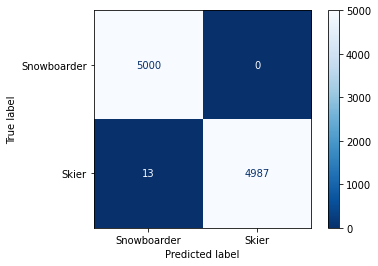

In [108]:
# print out classification metrics for analysis
model_confusion_matrix(logr_tvec,X,y)

## Saving Best Model Results

In [109]:
# pull the top score from each model
nb_cvec_model_scores = nb_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
nb_tvec_model_scores = nb_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
rf_cvec_model_scores = rf_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
rf_tvec_model_scores = rf_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
et_cvec_model_scores = et_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
et_tvec_model_scores = et_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
knn_cvec_model_scores = knn_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
knn_tvec_model_scores = knn_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
logr_cvec_model_scores = logr_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
logr_tvec_model_scores = logr_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()

In [110]:
# label each model
nb_cvec_model_scores.columns = ['nb cvec']
nb_tvec_model_scores.columns = ['nb tvec']
rf_cvec_model_scores.columns = ['rf cvec']
rf_tvec_model_scores.columns = ['rf tvec']
et_cvec_model_scores.columns = ['et cvec']
et_tvec_model_scores.columns = ['et tvec']
knn_cvec_model_scores.columns = ['knn cvec']
knn_tvec_model_scores.columns = ['knn tvec']
logr_cvec_model_scores.columns = ['logr cvec']
logr_tvec_model_scores.columns = ['logr tvec']

In [111]:
# create a dataframe of the top models scores
best_tests_5000_comments = pd.concat([nb_cvec_model_scores,nb_tvec_model_scores,
                        rf_cvec_model_scores,rf_tvec_model_scores,
                        et_cvec_model_scores,et_tvec_model_scores,
                        knn_cvec_model_scores,knn_tvec_model_scores,
                        logr_cvec_model_scores,logr_tvec_model_scores],axis = 1)

In [112]:
best_tests_5000_comments

,nb cvec,nb tvec,rf cvec,rf tvec,et cvec,et tvec,knn cvec,knn tvec,logr cvec,logr tvec
split0_test_score,0.8755,0.9140,0.8405,0.8040,0.8430,0.8610,0.9935,0.9980,0.9965,0.9990
split1_test_score,0.8875,0.9315,0.7995,0.7795,0.7770,0.8630,0.9920,0.9985,0.9950,0.9985
split2_test_score,0.8855,0.9260,0.8030,0.8025,0.7390,0.8620,0.9960,0.9975,0.9975,0.9980
split3_test_score,0.8740,0.9175,0.7705,0.8250,0.7475,0.9030,0.9935,0.9965,0.9965,0.9980
split4_test_score,0.8765,0.9145,0.7740,0.8225,0.7065,0.8645,0.9900,0.9945,0.9920,0.9960


In [113]:
# save top model scores
best_tests_5000_comments.to_csv('./data/best_tests_5000_comments.csv')